<a href="https://colab.research.google.com/github/Macostik/ML_cource/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing import sequence

from tensorflow import keras
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## Load data

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# Load data from IMDB csv file
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Ml course/IMBD/IMDB.csv')

## Data pre-processing

In [66]:
# Func for handle HTML to text
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())

# Transform HTML to text
data['review'] = data['review'].apply(lambda x : preprocessing_text(x))

# Encode target
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Look at result
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


Get data set info

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [68]:
data.shape

(50000, 2)

In [69]:
data['sentiment'].value_counts()

,count
sentiment,
1,25000
0,25000


In [70]:
# Split into input features and target variable
X = data['review']
y = data['sentiment']

# Convert tokens to ID
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
seq = tokenizer.texts_to_sequences(X)
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 2209), X_min: 0, X_max: 9999


In [71]:
# Split into training, valid and testing sets
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(30000, 2209) (10000, 2209) (10000, 2209) (30000,) (10000,) (10000,)


## Train model

In [72]:
# Create a model with one LSTM layer
model = keras.models.Sequential([
    keras.Input(shape=(None,)),
    keras.layers.Embedding(input_dim=10000, output_dim=64, mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Adam optimazer
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.7284 - loss: 0.5335 - val_accuracy: 0.8430 - val_loss: 0.3820
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.8117 - loss: 0.4382 - val_accuracy: 0.8353 - val_loss: 0.3889
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 66s 29ms/step - accuracy: 0.8827 - loss: 0.3024 - val_accuracy: 0.8687 - val_loss: 0.3212
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9152 - loss: 0.2272 - val_accuracy: 0.8771 - val_loss: 0.3013
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9337 - loss: 0.1784 - val_accuracy: 0.8759 - val_loss: 0.3182


<Axes: >

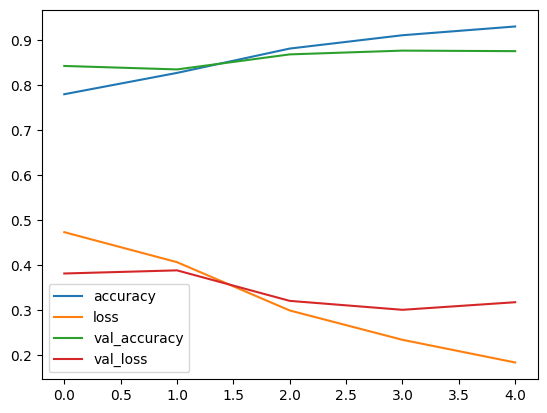

In [74]:
# Plot accuracy and loss values
pd.DataFrame(history.history).plot()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4961
           1       0.90      0.85      0.87      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



<Axes: >

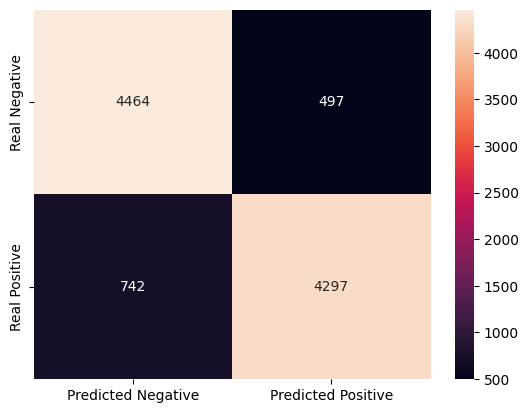

In [75]:
# Predict value
y_pred = np.round(model.predict(X_test)).astype(int)

print(classification_report(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='.0f',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Real Negative', 'Real Positive'])

The current model with one LSTM layer shows quite well result with 88% accuracy. But in the plot, we can observe that the model has overfitting by the test. Let's create more difficult model with at least two LSTM layers and compare result.

In [91]:
# Create a model with two LSTM layers
model_v2 = keras.models.Sequential([
    keras.Input(shape=(None,)),
    keras.layers.Embedding(input_dim=10000, output_dim=64, mask_zero=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, None, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706,113 (2.69 MB)

 Trainable params: 706,113 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Stop training if metrics have stopped improving
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# Compile model
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train second model
history_v2 = model_v2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 51s 53ms/step - accuracy: 0.6965 - loss: 0.5433 - val_accuracy: 0.8752 - val_loss: 0.3080
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.9054 - loss: 0.2502 - val_accuracy: 0.8882 - val_loss: 0.2738
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.9299 - loss: 0.1962 - val_accuracy: 0.8881 - val_loss: 0.2812
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9420 - loss: 0.1695 - val_accuracy: 0.8879 - val_loss: 0.2943
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.9514 - loss: 0.1431 - val_accuracy: 0.8808 - val_loss: 0.2909
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9548 - loss: 0.1352 - val_accuracy: 0.8853 - val_loss: 0.3004
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.9576 - loss: 0.1278 - val_accuracy: 0.8829 - val_loss: 0.3244


<Axes: >

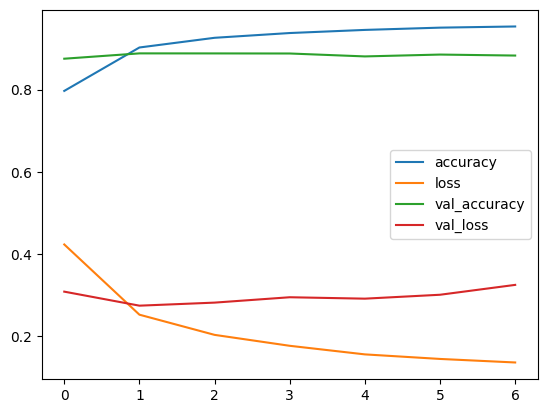

In [93]:
# Plot accuracy and loss values
pd.DataFrame(history_v2.history).plot()

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



<Axes: >

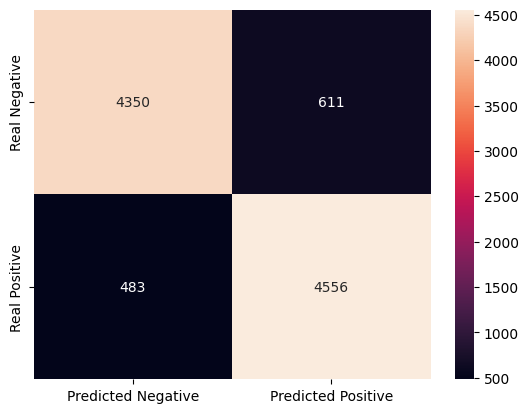

In [94]:
# Predict value
y_pred = np.round(model_v2.predict(X_test)).astype(int)

print(classification_report(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='.0f',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Real Negative', 'Real Positive'])

## Conclusion:

We successfully conducted experiments using the IMDB dataset to explore sentiment analysis with Recurrent Neural Networks. Two models with different LSTM layers and hyperparameter configurations were compared. While both models performed well during training, they exhibited signs of overfitting during testing. To mitigate overfitting, future steps could include experimenting with additional hyperparameter tuning, applying regularization techniques, and incorporating dropout layers. However, since the primary objective of this experiment was to review and understand the implementation of Recurrent Neural Networks, these refinements can be explored in subsequent studies. This work provides a solid foundation for further optimization and experimentation with sequential models.